3) Using the ACUCO symbols, align and orient the photograph 

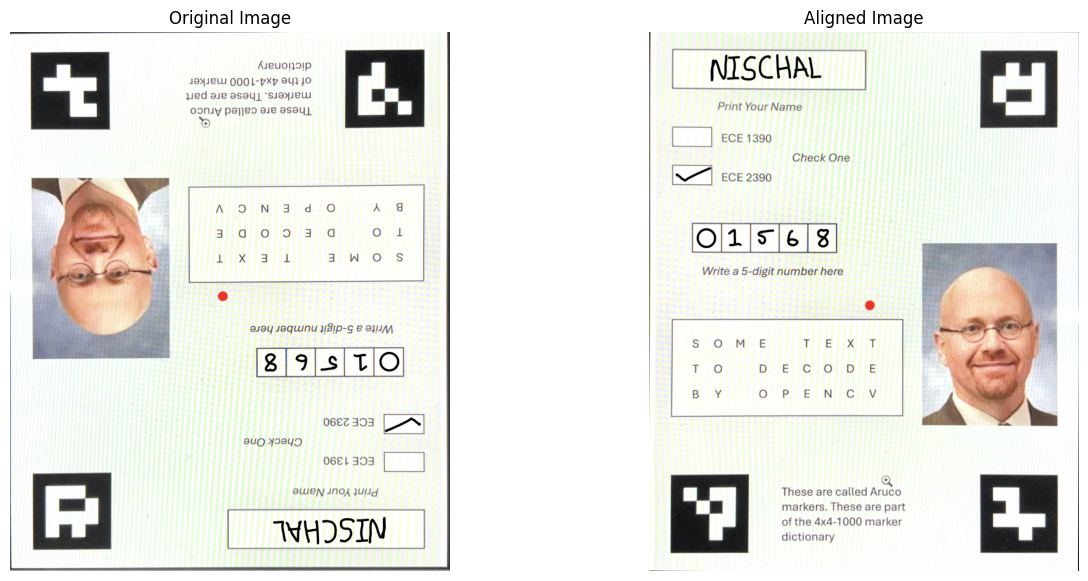

In [10]:
import cv2
import matplotlib.pyplot as plt
import cv2.aruco as aruco
import numpy as np

# Load the images
img_sideways = cv2.imread('hw8.png')
img_ref = cv2.imread('Homework8.jpg')

# Convert to grayscale
gray_sideways = cv2.cvtColor(img_sideways, cv2.COLOR_BGR2GRAY)
gray_ref = cv2.cvtColor(img_ref, cv2.COLOR_BGR2GRAY)

# Set up the ArUco dictionary and detector
dict_aruco = aruco.getPredefinedDictionary(aruco.DICT_4X4_1000)
params = aruco.DetectorParameters()
detector = aruco.ArucoDetector(dict_aruco, params)

# Find markers in both images
corners_sideways, ids_sideways, _ = detector.detectMarkers(gray_sideways)
corners_ref, ids_ref, _ = detector.detectMarkers(gray_ref)

# Check for enough markers in both images
if ids_sideways is None or ids_ref is None or len(ids_sideways) < 3 or len(ids_ref) < 3:
    print("Error: Not enough markers found.")
    exit()

# Match markers and store points
src_points = []
dst_points = []

for marker in ids_sideways.flatten():
    if marker in ids_ref.flatten():
        idx_sideways = np.where(ids_sideways.flatten() == marker)[0][0]
        idx_ref = np.where(ids_ref.flatten() == marker)[0][0]

        # Use the center of each marker for alignment
        src_points.append(corners_sideways[idx_sideways][0].mean(axis=0))
        dst_points.append(corners_ref[idx_ref][0].mean(axis=0))

# Ensure we have enough matching points
if len(src_points) < 3:
    print("Error: Need at least three matching markers.")
    exit()

# Calculate the transformation and align the image
src_points = np.array(src_points, dtype=np.float32)
dst_points = np.array(dst_points, dtype=np.float32)

affine_matrix = cv2.getAffineTransform(src_points[:3], dst_points[:3])
aligned_img = cv2.warpAffine(img_sideways, affine_matrix, (img_ref.shape[1], img_ref.shape[0]))

# Show the images
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

axs[0].imshow(cv2.cvtColor(img_sideways, cv2.COLOR_BGR2RGB))
axs[0].axis('off')
axs[0].set_title('Original Image')

axs[1].imshow(cv2.cvtColor(aligned_img, cv2.COLOR_BGR2RGB))
axs[1].axis('off')
axs[1].set_title('Aligned Image')

plt.show()


4) Using EasyOCR, read in the name box that you wrote

Detected Name: NISCHAL


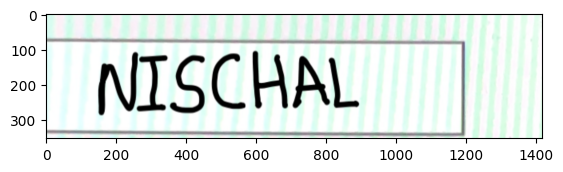

In [11]:
import easyocr

# Convert cm to pixels based on DPI
dpi = 300
cm_to_pixels = lambda cm: int((cm / 2.54) * dpi)

def crop_region(image, x_cm, y_cm, w_cm, h_cm):
    x = cm_to_pixels(x_cm) + image.shape[1] // 2 
    y = cm_to_pixels(y_cm) + image.shape[0] // 2  
    w = cm_to_pixels(w_cm)                        
    h = cm_to_pixels(h_cm)                        
    return image[max(0, y):y+h, max(0, x):x+w]    

# Initialize the OCR reader
reader = easyocr.Reader(['en'])

# Define the coordinates for the name box
name_box = crop_region(aligned_img, -10, -15, 12, 3)
plt.imshow(name_box)

# Perform OCR on the cropped region
name_result = reader.readtext(name_box)

# Check and print the detected name
if name_result:
    detected_name = name_result[0][1]
    print("Detected Name:", detected_name)
else:
    print("No name detected.")


5) Write code to check which of the two checkboxes is marked by comparing the intensity in the two boxes

In [12]:
def is_checkbox_marked(checkbox):
    gray = cv2.cvtColor(checkbox, cv2.COLOR_BGR2GRAY)
    return np.mean(gray) < 240  # Threshold to determine if it's marked

# Crop regions for checkboxes
checkbox_1390 = crop_region(aligned_img, -11, -10, 2.25, 1.25)
checkbox_2390 = crop_region(aligned_img, -11, -7.75, 2.25, 1.25)

# Check which checkbox is marked
is_1390_marked = is_checkbox_marked(checkbox_1390)
is_2390_marked = is_checkbox_marked(checkbox_2390)

# Print which checkbox is marked
if is_1390_marked:
    print("ECE-1390's checkbox is marked.")
elif is_2390_marked:
    print("ECE-2390's checkbox is marked.")
else:
    print("No checkbox is marked.")


ECE-2390's checkbox is marked.


6) Using the example from class on OCR-digits, decode the 5 numbers you wrote

0
1
5
6
8


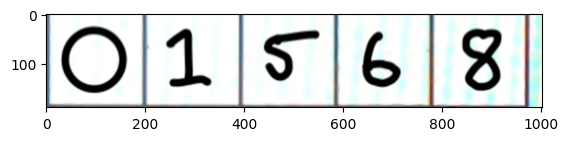

In [13]:
five_digits = crop_region(aligned_img, -9.8, -4.4, 8.5, 1.6) 
digit1 = crop_region(aligned_img, -9.8, -4.4, 1.5, 1.6)
digit2 = crop_region(aligned_img, -8.3, -4.4, 1.5, 1.6)
digit3 = crop_region(aligned_img, -6.6, -4.4, 1.5, 1.6)
digit4 = crop_region(aligned_img, -5, -4.4, 1.5, 1.6)
digit5 = crop_region(aligned_img, -3.3, -4.4, 1.5, 1.6)
plt.imshow(five_digits)
data = [ digit1,digit2,digit3,digit4,digit5]
digits = []
for i in range(1,6):
    print((reader.readtext(data[i-1]))[0][1])


Recognized Text:
Ss O M E T E X T
T O D ECO DE
B Y O P EN C V



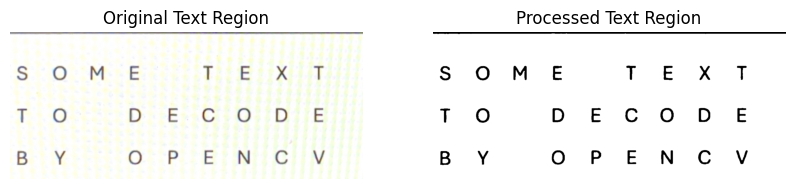

In [14]:
import pytesseract
import cv2
import matplotlib.pyplot as plt

# Define DPI and conversion function
dpi_value = 300
convert_to_px = lambda cm: int((cm / 2.54) * dpi_value)

def crop_area(img, x_offset, y_offset, width_cm, height_cm):
    """
    Crop a specific region from the image given its dimensions in cm.
    """
    x_coord = convert_to_px(x_offset) + img.shape[1] // 2
    y_coord = convert_to_px(y_offset) + img.shape[0] // 2
    width_px = convert_to_px(width_cm)
    height_px = convert_to_px(height_cm)

    # Crop the region while ensuring bounds
    return img[max(0, y_coord):y_coord + height_px, max(0, x_coord):x_coord + width_px]

# Crop the text box region
text_region = crop_area(aligned_img, -10, 1, 12, 5)

# Convert the cropped region to grayscale and apply thresholding
gray_region = cv2.cvtColor(text_region, cv2.COLOR_BGR2GRAY)
_, binary_region = cv2.threshold(gray_region, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Visualize the original and preprocessed text regions
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(text_region, cv2.COLOR_BGR2RGB))
plt.title("Original Text Region")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_region, cmap='gray')
plt.title("Processed Text Region")
plt.axis('off')

# Use Tesseract to extract text
ocr_config = r'--psm 6'  # Set Tesseract mode
recognized_text = pytesseract.image_to_string(binary_region, config=ocr_config)

# Display the extracted text
print("Recognized Text:")
print(recognized_text)


I0000 00:00:1733350276.292475  943165 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1733350276.306331  950917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


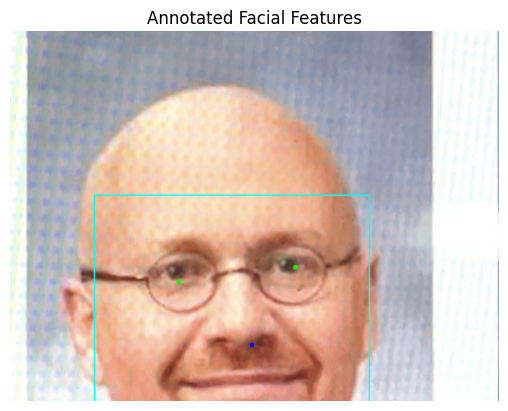

In [15]:
#Using MediaPipe, find the facial features for the image of Dr Huppert and draw the markers on the image.

import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

def convert_to_pixels(value_cm, resolution_dpi=300):
    """
    Convert a measurement in cm to pixels based on the specified DPI.
    """
    return int((value_cm / 2.54) * resolution_dpi)

def crop_face_area(image_input, area_cm):
    """
    Crop a specific region from the image in cm dimensions.
    """
    x_cm, y_cm, width_cm, height_cm = area_cm
    x_pixels = convert_to_pixels(x_cm) + image_input.shape[1] // 2
    y_pixels = convert_to_pixels(y_cm) + image_input.shape[0] // 2
    width_pixels = convert_to_pixels(width_cm)
    height_pixels = convert_to_pixels(height_cm)

    # Keep the crop within the image bounds
    x_start = max(0, x_pixels)
    x_end = min(image_input.shape[1], x_start + width_pixels)
    y_start = max(0, y_pixels)
    y_end = min(image_input.shape[0], y_start + height_pixels)

    return image_input[y_start:y_end, x_start:x_end]

def find_facial_features(input_image, face_area):
    """
    Detect facial landmarks in the provided image area and draw markers.
    """
    # Crop the region containing the face
    cropped_face = crop_face_area(input_image, face_area)

    plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
    plt.title("Face Area")
    plt.axis('off')

    # Initialize MediaPipe face detection
    face_detector = mp.solutions.face_detection.FaceDetection(
        model_selection=0, min_detection_confidence=0.6
    )

    # Convert the face region to RGB for MediaPipe processing
    face_rgb = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)

    # Perform face detection
    detection_results = face_detector.process(face_rgb)

    # Create a copy of the cropped image to annotate
    marked_image = cropped_face.copy()
    for detected_face in detection_results.detections:
        # Draw bounding rectangle
        bbox = detected_face.location_data.relative_bounding_box
        x, y, width, height = (
            int(bbox.xmin * marked_image.shape[1]),
            int(bbox.ymin * marked_image.shape[0]),
            int(bbox.width * marked_image.shape[1]),
            int(bbox.height * marked_image.shape[0]),
        )
        cv2.rectangle(marked_image, (x, y), (x + width, y + height), (255, 255, 0), 2)

        # Highlight key points (e.g., eyes, nose tip)
        key_points = detected_face.location_data.relative_keypoints
        for index, color in zip([0, 1, 2], [(0, 255, 0), (0, 255, 0), (255, 0, 0)]):  # Green for eyes, blue for nose
            key_x = int(key_points[index].x * marked_image.shape[1])
            key_y = int(key_points[index].y * marked_image.shape[0])
            cv2.circle(marked_image, (key_x, key_y), 5, color, -1)

    # Display the image with facial features annotated
    plt.imshow(cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB))
    plt.title("Annotated Facial Features")
    plt.axis('off')

# Define the face area in cm (X, Y, Width, Height)
area_to_crop = [3, -3, 10, 7]

# Call the function to detect and annotate facial features
find_facial_features(aligned_img, area_to_crop)
